# Implementation Approach 1 (Identify Hough Lines)

In [16]:
import cv2
import numpy as np
from IPython.display import Image

In [95]:
file_path = 'test.jpg'

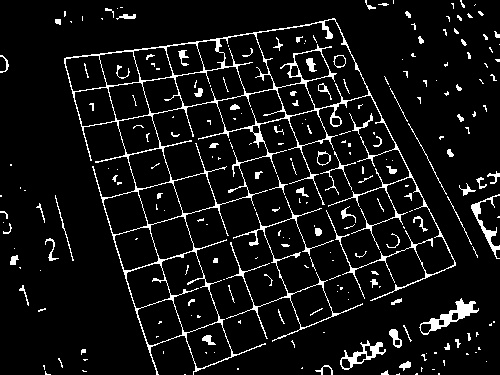

In [96]:
apply_filter = False

img = cv2.imread(file_path)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,90,150,apertureSize = 3)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(edges,kernel,iterations = 1)
kernel = np.ones((5,5),np.uint8)
edges = cv2.erode(edges,kernel,iterations = 1)
cv2.imwrite('canny.jpg',edges)

# Display image (only supported in ipynb)
Image('canny.jpg')


In [97]:
lines = cv2.HoughLines(edges,1,np.pi/180,150)
    
if not lines.any():
    print('No lines were found')
else:
    if apply_filter:
        rho_threshold = 15
        theta_threshold = 0.1

        # how many lines are similar to a given one
        similar_lines = {i : [] for i in range(len(lines))}
        for i in range(len(lines)):
            for j in range(len(lines)):
                if i == j:
                    continue

                rho_i,theta_i = lines[i][0]
                rho_j,theta_j = lines[j][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    similar_lines[i].append(j)

        # ordering the INDECES of the lines by how many are similar to them
        indices = [i for i in range(len(lines))]
        indices.sort(key=lambda x : len(similar_lines[x]))

        # line flags is the base for the filtering
        line_flags = len(lines)*[True]
        for i in range(len(lines) - 1):
            if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
                continue

            for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
                if not line_flags[indices[j]]: # and only if we have not disregarded them already
                    continue

                rho_i,theta_i = lines[indices[i]][0]
                rho_j,theta_j = lines[indices[j]][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    print('number of Hough lines:', len(lines))

number of Hough lines: 33


In [98]:
filtered_lines = []
print("Apply Filter: {}".format(apply_filter))
if apply_filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

Apply Filter: False


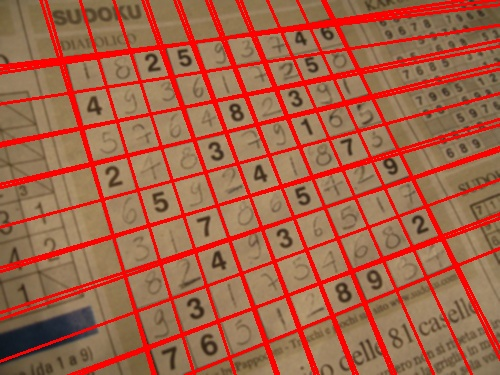

In [99]:
for line in filtered_lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('hough.jpg',img)
Image('hough.jpg')

# Implementation Approach 2 (Find Hough Intersections)
**See:** https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

In [21]:
import cv2
import numpy as np
from IPython.display import Image

In [100]:
file_path = '../../Images/sudoku-original.jpg'

First, we'll just read this image and binarize it using adaptive thresholding like what's used in this [OpenCV tutorial](http://docs.opencv.org/3.2.0/d7/d4d/tutorial_py_thresholding.html):

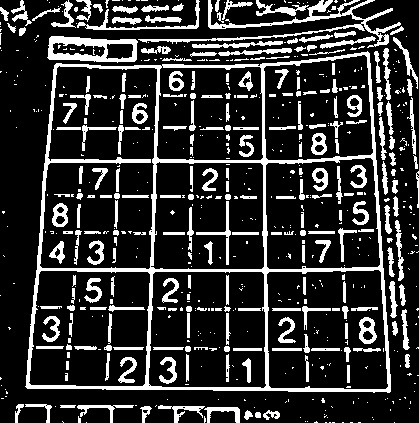

In [101]:
img = cv2.imread(file_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresh_type = cv2.THRESH_BINARY_INV
bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)
cv2.imwrite('binary.jpg',bin_img)
Image('binary.jpg')

Then we'll find the Hough lines with **cv2.HoughLines()**

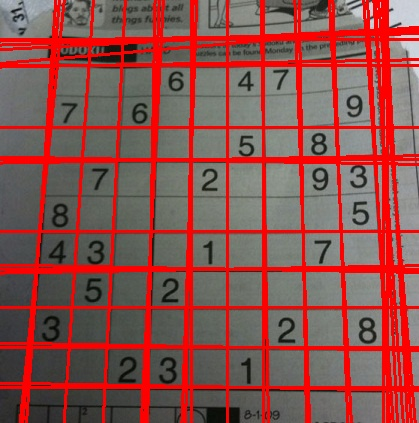

In [102]:
rho, theta, thresh = 2, np.pi/180, 400
lines = cv2.HoughLines(bin_img, rho, theta, thresh)

for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('hough.jpg',img)
Image('hough.jpg')

Now, if we want to find the intersections, really we want to find the intersections only of the perpendicular lines. We don't want the intersections of mostly parallel lines. So we need to segment our lines. In this particular example you could easily just check whether the line is horizontal or vertical based on a simple test; the vertical lines will have a ```theta``` of around 0 or around 180; the horizontal lines will have a ```theta``` of around 90. However, if you want to segment them based on an arbitrary number of angles, automatically, without you defining those angles, I think the best idea is to use ```cv2.kmeans()```.

There is one tricky thing to get right. ```HoughLines``` returns lines in ```rho, theta``` form ([Hesse normal form](https://en.wikipedia.org/wiki/Hesse_normal_form)), and the ```theta``` returned is between 0 and 180 degrees, and lines around 180 and 0 degrees are similar (they are both close to horizontal lines), so we need some way to get this periodicity in ```kmeans```.

If we plot the angle on the unit circle, but multiply the angle by two, then the angles originally around 180 degrees will become close to 360 degrees and thus will have ```x, y``` values on the unit circle near the same for angles at 0. So we can get some nice "closeness" here by plotting 2*angle with the coordinates on the unit circle. Then we can run ```cv2.kmeans()``` on those points, and segment automatically with however many pieces we want.

So let's build a function to do the segmentation:

In [103]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

Now to use it, we can simply call:

In [104]:
segmented = segment_by_angle_kmeans(lines)

In [105]:
print("Groups: {}".format(len(segmented)))

Groups: 2


What's nice is here we can specify an arbitrary number of groups by specifying the optional argument ```k``` (by default, ```k = 2``` so I didn't specify it here).

If we plot the lines from each group with a different color:

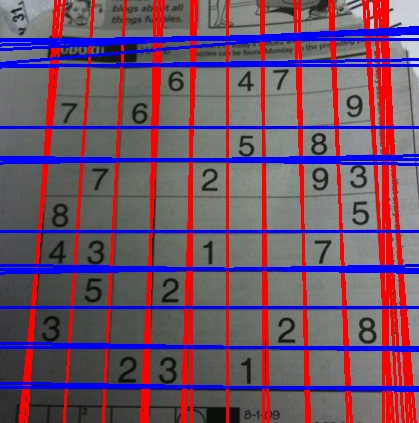

In [106]:
group1_color = (0,0,255)
group2_color = (255,0,0)

line_group1 = segmented[0]
line_group2 = segmented[1]

for line in line_group1:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),group1_color,2)
    
for line in line_group2:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),group2_color,2)
    
cv2.imwrite('hough_grouped.jpg',img)
Image('hough_grouped.jpg')

And now all that's left is to find the intersections of each line in the first group with the intersection of each line in the second group. Since the lines are in Hesse normal form, there's a nice linear algebra formula for calculating the intersection of lines from this form. See [here](https://stackoverflow.com/questions/383480/intersection-of-two-lines-defined-in-rho-theta-parameterization). Let's create two functions here; one that finds the intersection of just two lines, and one function that loops through all the lines in the groups and uses that simpler function for two lines:

In [107]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

In [108]:
def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

Then to use it, it's simply:

In [109]:
intersections = segmented_intersections(segmented)

In [110]:
intersections

[[[263, 388]],
 [[263, 269]],
 [[263, 387]],
 [[263, 159]],
 [[263, 347]],
 [[263, 307]],
 [[263, 158]],
 [[263, 268]],
 [[263, 36]],
 [[263, 270]],
 [[263, 231]],
 [[263, 36]],
 [[263, 162]],
 [[263, 348]],
 [[263, 39]],
 [[263, 40]],
 [[263, 127]],
 [[263, 65]],
 [[263, 62]],
 [[263, 35]],
 [[146, 386]],
 [[150, 269]],
 [[146, 387]],
 [[154, 159]],
 [[147, 347]],
 [[148, 307]],
 [[153, 160]],
 [[150, 270]],
 [[158, 40]],
 [[150, 268]],
 [[151, 231]],
 [[158, 38]],
 [[154, 160]],
 [[147, 346]],
 [[158, 39]],
 [[157, 49]],
 [[155, 127]],
 [[157, 65]],
 [[157, 64]],
 [[158, 41]],
 [[391, 390]],
 [[383, 269]],
 [[391, 387]],
 [[375, 159]],
 [[388, 347]],
 [[385, 307]],
 [[375, 156]],
 [[383, 266]],
 [[366, 32]],
 [[383, 272]],
 [[380, 231]],
 [[366, 35]],
 [[375, 164]],
 [[388, 350]],
 [[367, 39]],
 [[366, 31]],
 [[373, 127]],
 [[368, 65]],
 [[368, 61]],
 [[366, 30]],
 [[268, 388]],
 [[266, 269]],
 [[268, 387]],
 [[264, 159]],
 [[267, 347]],
 [[266, 307]],
 [[264, 158]],
 [[266, 268]],
 

In [111]:
len(intersections)

540

And plotting all the intersections, we get:

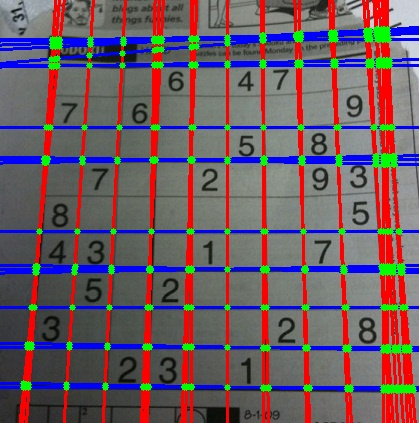

In [112]:
for intersection in intersections:
    point = tuple(intersection[0])
    cv2.line(img,point,point,(0, 255, 0),5)

cv2.imwrite('hough_intersections.jpg',img)
Image('hough_intersections.jpg')